Imports

In [1]:
import mediapipe as mp
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler    
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

# Load DATA

In [2]:
# The data labels are in the form below:
alphabet = ['1', '2', '3','4', 'space', 'del', 
'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
labels_ = alphabet
NUM_CLASSES = len(labels_)

In [59]:
x_flat = pd.read_csv("./data/train/x_data900.csv") 
y_flat = pd.read_csv("./data/train/y_data900.csv")  #Note the first column of this is the index, so it's nx2 size

x_flat_test = pd.read_csv("./data/test/x_data_test50.csv")
y_flat_test = pd.read_csv("./data/test/y_data_test50.csv") #Note the first column of this is the index, so it's nx2 size



In [60]:
# We need to unflatten
def unflatten(df,shape):
    """ 
    reshape a dataframe to the correct array size
    shape is an array ex [21,3] which describes the desired shape
    """
    old_array = df.to_numpy()
    new_array = []
    for point in old_array:
        point_reshaped = point.reshape(shape[0], shape[1])
        new_array.append(point_reshaped)

    return np.array(new_array)

# TEST
arr = np.array([[1,2,3,4,5,6,7,8],[1,2,3,4,5,6,7,8],[1,2,3,4,5,6,7,8]])
arr = pd.DataFrame(arr)
unflatten(arr,shape=[2,4])



array([[[1, 2, 3, 4],
        [5, 6, 7, 8]],

       [[1, 2, 3, 4],
        [5, 6, 7, 8]],

       [[1, 2, 3, 4],
        [5, 6, 7, 8]]])

In [61]:
#revert the data back into its original form
x_data = unflatten(x_flat,shape=[21,3])
X_test = unflatten(x_flat_test,shape=[21,3])

#Adjust labels to numpy array
y_data = y_flat.to_numpy()
y_test = y_flat_test.to_numpy()

print("training data shape:", np.shape(x_data), "training score's shape", np.shape(y_data))
print("testing data shape:", np.shape(X_test), "testing score's shape", np.shape(y_test))


training data shape: (24367, 21, 3) training score's shape (24367, 1)
testing data shape: (1496, 21, 3) testing score's shape (1496, 1)


In [62]:
# Validation split
X_train, X_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.1)

In [63]:
#One hot encode
y_train = to_categorical(y_train).astype(int)
y_valid = to_categorical(y_valid).astype(int)
y_test = to_categorical(y_test).astype(int)

Now we can train our models. 

# Modeling
Our inputs are:
- X_Train, y_train 
- X_valid, y_valid
- X_test,y_test
Each datapoint in the Xs are [21,3]

In [8]:
# Setup checkpoint
import os
import tensorflow as tf

checkpoint_path = "./checkpoints.ckpt/"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# define the model architecture
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(21, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=NUM_CLASSES, activation='softmax'))

#Compile
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [10]:
model.fit(X_train, y_train, epochs=5, callbacks=[cp_callback],validation_data=(X_valid, y_valid))

Epoch 1/5
685/686 [============================>.] - ETA: 0s - loss: 1.0551 - categorical_accuracy: 0.7722
Epoch 1: saving model to ./checkpoints.ckpt\
686/686 [==============================] - 2s 2ms/step - loss: 1.0547 - categorical_accuracy: 0.7723 - val_loss: 0.2440 - val_categorical_accuracy: 0.9676
Epoch 2/5
681/686 [============================>.] - ETA: 0s - loss: 0.1952 - categorical_accuracy: 0.9710
Epoch 2: saving model to ./checkpoints.ckpt\
686/686 [==============================] - 1s 2ms/step - loss: 0.1956 - categorical_accuracy: 0.9710 - val_loss: 0.1439 - val_categorical_accuracy: 0.9848
Epoch 3/5
686/686 [==============================] - ETA: 0s - loss: 0.1287 - categorical_accuracy: 0.9810
Epoch 3: saving model to ./checkpoints.ckpt\
686/686 [==============================] - 1s 2ms/step - loss: 0.1287 - categorical_accuracy: 0.9810 - val_loss: 0.1085 - val_categorical_accuracy: 0.9881
Epoch 4/5
681/686 [============================>.] - ETA: 0s - loss: 0.1026 - c

In [57]:
# Evaluate on the test set: 
score = model.evaluate(np.array(X_test), y_test, verbose = 0) 
print(f"Accuracy: {score[1]}")
print(f"Loss: {score[0]}")

if score[1]> 0.95:
    model.save(f"./model_saves/my_model")

Accuracy: 0.982574999332428
Loss: 0.08960341662168503


INFO:tensorflow:Assets written to: ./model_saves/my_model\assets


INFO:tensorflow:Assets written to: ./model_saves/my_model\assets


47/47 [==============================] - 0s 1ms/step


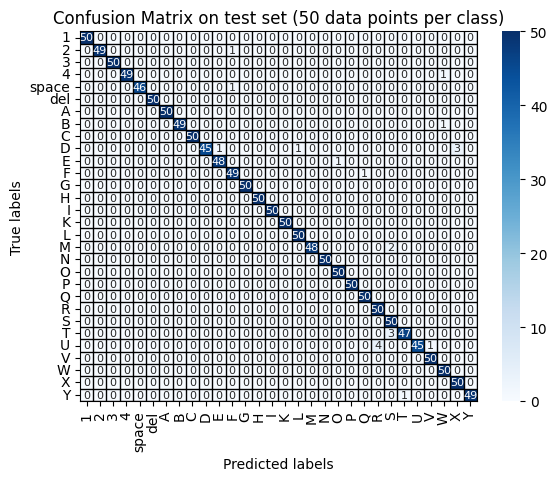

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

preds = model.predict(np.array(X_test))
preds =  np.argmax(preds,axis=1)
cm = confusion_matrix(np.argmax(y_test,axis=1), preds)
# print(cm)
class_labels = labels_

class_percentages = cm / cm.sum(axis=1)[:, np.newaxis]

# create a heatmap of the confusion matrix with class labels and percentages
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels, cbar=True, annot_kws={"size": 8})
# create a heatmap of the confusion matrix
# ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels, cbar=True,annot_kws={"size": 8})
# ax.grid(True, color='black')
# ax.grid(which='both', color='black', linewidth=1.5)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')

ax.hlines([y + 1 for y in range(len(class_labels) + 1)], 0, len(class_labels), colors='black', linewidths=1)
ax.vlines([x + 1 for x in range(len(class_labels) + 1)], 0, len(class_labels), colors='black', linewidths=1)


# add total counts below the confusion matrix
total_counts = np.sum(cm, axis=0)  # compute the total counts for each predicted class
# # Add total counts below the confusion matrix
# for i, count in enumerate(total_counts):
#     ax.annotate(f"n={count}", xy=(i + 0.5, -0.3), xycoords='axes fraction', ha='center', fontsize=6)
# add axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on test set (50 data points per class)')
# show the plot
plt.show()

Average precision: 0.9860354322516075
Average recall: 0.985277174699667
Average F1-score: 0.9852608628988271


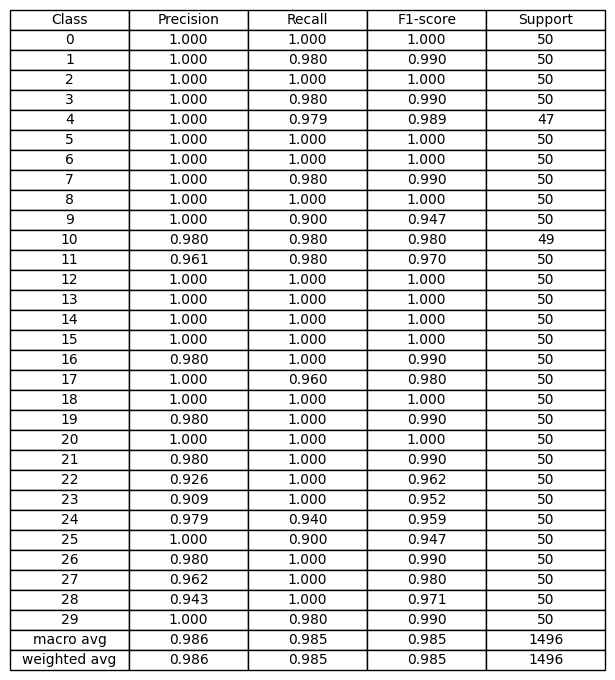

In [80]:
# Metrics:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from tabulate import tabulate


report = classification_report(np.argmax(y_test,axis=1), preds, output_dict=True)

precision = precision_score(np.argmax(y_test,axis=1), preds, average='macro')
recall = recall_score(np.argmax(y_test,axis=1), preds, average='macro')
f1 = f1_score(np.argmax(y_test,axis=1), preds, average='macro')

print('Average precision:', precision)
print('Average recall:', recall)
print('Average F1-score:', f1)
# print(report)


# Convert the report to a table
table = []
headers = ['Class', 'Precision', 'Recall', 'F1-score', 'Support']
for class_label, metrics in report.items():
    if class_label != 'accuracy':
        row = [class_label,
               f"{metrics['precision']:.3f}",  # Truncate precision to 3 decimal places
               f"{metrics['recall']:.3f}",  # Truncate recall to 3 decimal places
               f"{metrics['f1-score']:.3f}",  # Truncate F1-score to 3 decimal places
               metrics['support']]
        table.append(row)
# Print the table
# print(tabulate(table, headers=headers, tablefmt='grid'))
# Create a figure and axis
fig, ax = plt.subplots()

# Create the table plot
table_plot = ax.table(cellText=table, colLabels=headers, cellLoc='center', loc='center')

# Customize the table appearance
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(10)
table_plot.scale(1.2, 1.2)  # Adjust the table size if needed

# Hide axis
ax.axis('off')

# Save the figure as a PNG image
plt.savefig('classification_report.png', bbox_inches='tight', dpi=300)

# Display the table
plt.show()


84/84 [==============================] - 0s 2ms/step


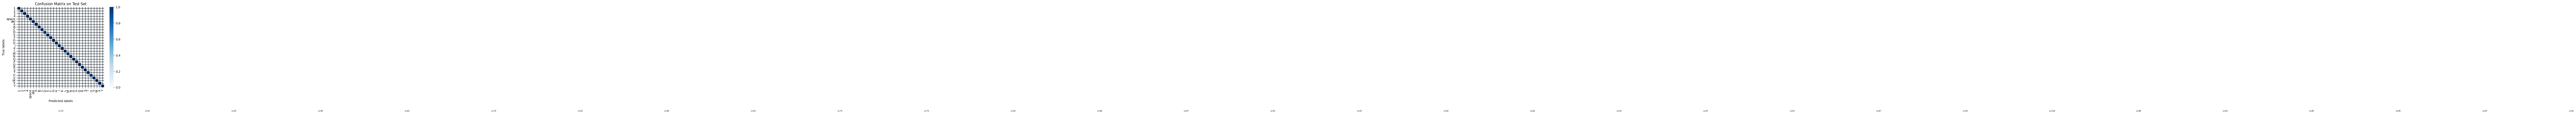

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

preds = model.predict(np.array(X_test))
preds = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, preds)
class_labels = labels_

# Compute class percentages
class_percentages = cm / cm.sum(axis=1)[:, np.newaxis]

# Compute total counts for each predicted class
total_counts = np.sum(cm, axis=0)

# Create a heatmap of the confusion matrix with class labels and percentages
ax = sns.heatmap(class_percentages, annot=False, cmap='Blues', fmt='.1%', xticklabels=class_labels, yticklabels=class_labels, cbar=True, annot_kws={"size": 5})

# Add grid lines along the edges of the grid
ax.hlines([y + 0.5 for y in range(len(class_labels))], 0, len(class_labels), colors='black', linewidths=1)
ax.vlines([x + 0.5 for x in range(len(class_labels))], 0, len(class_labels), colors='black', linewidths=1)

# Add total counts below the confusion matrix
for i, count in enumerate(total_counts):
    ax.annotate(f"n={count}", xy=(i + 0.5, -0.3), xycoords='axes fraction', ha='center', fontsize=6)

# Add axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Test Set')

# Show the plot
plt.show()


# Video Demo
Now let's see how this performs live!

In [18]:
# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
        model_complexity=0,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
          print("Ignoring empty camera frame.")
          # If loading a video, use 'break' instead of 'continue'.
          continue

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        landmarks = []
        letter = ''
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())
                
                # Get the bounding box of the hand
                x_min, y_min, x_max, y_max = float('inf'), float('inf'), float('-inf'), float('-inf')
                for landmark in hand_landmarks.landmark:
                    x, y = landmark.x, landmark.y
                    x_min = min(x_min, x)
                    y_min = min(y_min, y)
                    x_max = max(x_max, x)
                    y_max = max(y_max, y)

                # Normalize the coordinates with respect to the bounding box of the hand
                for landmark in hand_landmarks.landmark:
                    x, y, z = landmark.x, landmark.y, landmark.z
                    x_norm = (x - x_min) / (x_max - x_min)
                    y_norm = (y - y_min) / (y_max - y_min)
                    landmarks.append([x_norm, y_norm, z])

            # Convert the landmarks to a feature vector
            x_t = np.array(landmarks)
                        
            
            if x_t.flatten().shape[0] == 63:
            
                res_ = model.predict(np.array([x_t]), verbose = 0)

                index_class = np.argmax(res_)

                letter = alphabet[index_class]
            # Double hand special case
            elif x_t.flatten().shape[0] == 126:

                a = x_t[:21,:]

                b = x_t[21:,:]

                res_ = model.predict(np.array([a]), verbose = 0)

                index_class = np.argmax(res_)

                output = alphabet[index_class]

                res_1 = model.predict(np.array([b]), verbose = 0)

                index_class1 = np.argmax(res_1)

                output1 = alphabet[index_class1]
                # For fun
                if output == 'Y' and output1 == 'Y':

                    letter = 'Sup Brah'

                elif output == "V" and output1 == 'V':
                    letter = "Peace Among Worlds"

                elif (output == "H" and output1 == 'I') or (output == "I" and output1 == 'H'):
                    letter = "Hi yourself"
            


        # Flip the image horizontally for a selfie-view display.
        
        
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (100,50)
        fontScale              = 1
        fontColor              = (0,0,0)
        thickness              = 4
        lineType               = 2

        image = cv2.putText(cv2.flip(image, 1),letter, 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            thickness,
            lineType)
        
        
        cv2.imshow('MediaPipe Hands', image)
            
        
        if cv2.waitKey(5) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            cv2.waitKey(1)
            break
